## Project 2  - Predictive Analysis

1. Eyal Greeberg
2. Lindsay Vitovsky

## Data Preparation (15 points total)

#### [10 points] Define and prepare you class variables.  Use proper variable representations (int, float, one-hot, etc.).  Use pre-processing methods as needed for dimensionality reduction, scaling, etc.  Remove variables that are not needed/useful for the analysis.


In [1]:
# Import the required packages and load the Census Income dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from matplotlib import pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from ipywidgets import widgets

header_names = ('age', 'workclass', 'fnlwgt', 'education', 'educationnum', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'nativecountry', 'income')
censusdata = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=',', header=None) # read in the csv file
censusdata.columns = header_names

censusdata.head()

,age,workclass,fnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
# remove spaces before the text columns
censusdata['workclass'] = censusdata['workclass'].map(str.strip)
censusdata['education'] = censusdata['education'].map(str.strip)
censusdata['maritalstatus'] = censusdata['maritalstatus'].map(str.strip)
censusdata['occupation'] = censusdata['occupation'].map(str.strip)
censusdata['relationship'] = censusdata['relationship'].map(str.strip)
censusdata['race'] = censusdata['race'].map(str.strip)
censusdata['sex'] = censusdata['sex'].map(str.strip)
censusdata['nativecountry'] = censusdata['nativecountry'].map(str.strip)
censusdata['income'] = censusdata['income'].map(str.strip)

In [3]:
# convert int to float for a future use of StandardScaler (see below)
censusdata.age = censusdata.age.astype(float)
censusdata.educationnum = censusdata.educationnum.astype(float)
censusdata.hoursperweek = censusdata.hoursperweek.astype(float)

In [4]:
# Remove attributes we don't need
# 'fnlwgt' was used by the oringal researchers to decide how much 
# weighting should be given to the various ethnic groups for their interpretations.
# 'capitalgain' and 'capitalloss' were mostly blank, and after researching their
# purpose, we found them to be fraught with complications.  
del censusdata['fnlwgt']
del censusdata['capitalgain']
del censusdata['capitalloss']

In [5]:
# Replace the current sex atribute with something slightly more intuitive and readable, 
# and then delete the original column
censusdata['IsMale'] = censusdata.sex=='Male' 
censusdata.IsMale = censusdata.IsMale.astype(np.int)
if 'sex' in censusdata: del censusdata['sex']
    
# Replace the current income atribute with something slightly more intuitive and readable,
# and then delete the original column
censusdata['IsIncomeAbove50k'] = censusdata.income=='>50K' 
censusdata.IsIncomeAbove50k = censusdata.IsIncomeAbove50k.astype(np.int)
if 'income' in censusdata: del censusdata['income']

censusdata.head(n=10)

,age,workclass,education,educationnum,maritalstatus,occupation,relationship,race,hoursperweek,nativecountry,IsMale,IsIncomeAbove50k
0,39.0,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,40.0,United-States,1,0
1,50.0,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,13.0,United-States,1,0
2,38.0,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,40.0,United-States,1,0
3,53.0,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,40.0,United-States,1,0
4,28.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,40.0,Cuba,0,0
5,37.0,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,40.0,United-States,0,0
6,49.0,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,16.0,Jamaica,0,0
7,52.0,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,45.0,United-States,1,1
8,31.0,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,50.0,United-States,0,1
9,42.0,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,40.0,United-States,1,1


In [6]:
# perform one-hot encoding of the categorical data columns, and then delete the original column
# 1. workclass
tmp_df = pd.get_dummies(censusdata.workclass,prefix='workclass')
censusdata = pd.concat((censusdata,tmp_df),axis=1) # add back into the dataframe

# 2. education
tmp_df = pd.get_dummies(censusdata.education,prefix='education')
censusdata = pd.concat((censusdata,tmp_df),axis=1) # add back into the dataframe

# 3. maritalstatus
tmp_df = pd.get_dummies(censusdata.maritalstatus,prefix='maritalstatus')
censusdata = pd.concat((censusdata,tmp_df),axis=1) # add back into the dataframe

# 4. occupation
tmp_df = pd.get_dummies(censusdata.occupation,prefix='occupation')
censusdata = pd.concat((censusdata,tmp_df),axis=1) # add back into the dataframe

# 5. relationship
tmp_df = pd.get_dummies(censusdata.relationship,prefix='relationship')
censusdata = pd.concat((censusdata,tmp_df),axis=1) # add back into the dataframe

# 6. race
tmp_df = pd.get_dummies(censusdata.race,prefix='race')
censusdata = pd.concat((censusdata,tmp_df),axis=1) # add back into the dataframe

# 7. nativecountry
tmp_df = pd.get_dummies(censusdata.nativecountry,prefix='nativecountry')
censusdata = pd.concat((censusdata,tmp_df),axis=1) # add back into the dataframe

censusdata.head()

,age,workclass,education,educationnum,maritalstatus,occupation,relationship,race,hoursperweek,nativecountry,...,nativecountry_Portugal,nativecountry_Puerto-Rico,nativecountry_Scotland,nativecountry_South,nativecountry_Taiwan,nativecountry_Thailand,nativecountry_Trinadad&Tobago,nativecountry_United-States,nativecountry_Vietnam,nativecountry_Yugoslavia
0,39.0,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,40.0,United-States,...,0,0,0,0,0,0,0,1,0,0
1,50.0,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,13.0,United-States,...,0,0,0,0,0,0,0,1,0,0
2,38.0,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,40.0,United-States,...,0,0,0,0,0,0,0,1,0,0
3,53.0,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,40.0,United-States,...,0,0,0,0,0,0,0,1,0,0
4,28.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,40.0,Cuba,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# clean the original columns (if they still exist)
if 'workclass' in censusdata: del censusdata['workclass']
if 'education' in censusdata: del censusdata['education']
if 'maritalstatus' in censusdata: del censusdata['maritalstatus']
if 'occupation' in censusdata: del censusdata['occupation']
if 'relationship' in censusdata: del censusdata['relationship']
if 'race' in censusdata: del censusdata['race']
if 'nativecountry' in censusdata: del censusdata['nativecountry']
censusdata.head()

,age,educationnum,hoursperweek,IsMale,IsIncomeAbove50k,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,nativecountry_Portugal,nativecountry_Puerto-Rico,nativecountry_Scotland,nativecountry_South,nativecountry_Taiwan,nativecountry_Thailand,nativecountry_Trinadad&Tobago,nativecountry_United-States,nativecountry_Vietnam,nativecountry_Yugoslavia
0,39.0,13.0,40.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50.0,13.0,13.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38.0,9.0,40.0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53.0,7.0,40.0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28.0,13.0,40.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
censusdata.to_csv(path_or_buf='/Users/eyalgreenberg/Google Drive/MS Data Science SMU/5 Data Mining/Projects/project2/taskone.csv',sep=',')
taskone = censusdata.copy()
tasktwo = censusdata.copy()

# pd.set_option('display.max_rows', 10000)
# print (tasktwo.dtypes)

In [9]:
# Task one
## Let's assume that we are a private scholl, and we want to sell a higher education service.
## We are looking to predict people with lower education than a bachelor.

# First, we will create a new column with these people
taskone['EducationLessThanMaster'] = np.where((taskone['education_Bachelors']!=1) & 
                                              (taskone['education_Masters']!=1) &
                                              (taskone['education_Doctorate']!=1), 1, 0)

# We assume that we don't have the total number of education years (otherwise it's going to be to easy..)
#, so let's remove this column-
if 'educationnum' in taskone: del taskone['educationnum']
if 'education_Bachelors' in taskone: del taskone['education_Bachelors']
if 'education_Masters' in taskone: del taskone['education_Masters']
if 'education_Doctorate' in taskone: del taskone['education_Doctorate']
if 'education_10th' in taskone: del taskone['education_10th']
if 'education_11th' in taskone: del taskone['education_11th']
if 'education_12th' in taskone: del taskone['education_12th']
if 'education_1st-4th' in taskone: del taskone['education_1st-4th']
if 'education_5th-6th' in taskone: del taskone['education_5th-6th']
if 'education_7th-8th' in taskone: del taskone['education_7th-8th']
if 'education_9th' in taskone: del taskone['education_9th']
if 'education_Assoc-acdm' in taskone: del taskone['education_Assoc-acdm']
if 'education_Assoc-voc' in taskone: del taskone['education_Assoc-voc']
if 'education_HS-grad' in taskone: del taskone['education_HS-grad']
if 'education_Preschool' in taskone: del taskone['education_Preschool']
if 'education_Prof-school' in taskone: del taskone['education_Prof-school']
if 'education_Some-college' in taskone: del taskone['education_Some-college']


# pd.set_option('display.max_columns', 10000)
# taskone.head(n=30)
# pd.set_option('display.max_rows', 10000)
# print (taskone.dtypes)

In [10]:
# Task two
## Let's assume that we are a non for profit women in golden age organization. We want to
## identify women above the age of 62, in in order to reach out to them and market our services.
## We are looking therefore to predict women above 62.

# First, we will create a new column with these people
tasktwo['WomenAbove62'] = np.where((tasktwo['age']>62) & 
                                   (tasktwo['IsMale']==0), 1, 0)

# remove these columns-
if 'age' in tasktwo: del tasktwo['age']
if 'IsMale' in tasktwo: del tasktwo['IsMale']

    
# pd.set_option('display.max_columns', 10000)
# tasktwo.head(n=30)
# pd.set_option('display.max_rows', 10000)
# print (tasktwo.dtypes)

#### [5 pts] Describe the final dataset that is used for classification / regression (include a description of any newly formed variables you created). 

To summarize the datsets (in addition to the comments we have put in the code above to describe what we did), we have created two tasks datasets:<enter>

Taskone-
<enter>
The dataset include the original variables, but not the "educationnum" variable. We deleted this variable as we assume for the bussiness case that this variable would not be available.
We have created the "EducationLessThanMaster" variable that has the value 1 if the person has an education less than a bachelor (so no bachelor, master or doctorate), and 0 otherwise.
The dataset will be used for a classification of the feature "EducationLessThanMaster", based on the other features.
<enter>
Tasktwo-
<enter>
The dataset include the original variables, but not the "age" and "IsMale" variables. We deleted these variables as we assume for the bussiness case that these variables would not be available.
We have created the "WomenAbove62" variable that has the value 1 if the person is a woman above the age of 62, and 0 otherwise.
The dataset will be used for a classification of the feature "WomenAbove62", based on the other features.

## Modeling and Evaluation (70 points total)

#### [10 points] Choose and explain your evaluation metrics that you will use (i.e. accuracy, precision, recall, f-measure, or any metric we have discussed).  Why are the measure(s) appropriate for the analyzing the results of your modeling? Give a detailed description and backup any assertions.

For taskone, we assume that the information (a list of people with a lower than bachelor degree) will be used to market a bachelor degree service. The school will call and invest marketing time (=money!) in each potential candidate. We can assume that calling someone who already has a Bachelor (or higher degree), won't lead to selling them another bachelor. Therefore, we want to avoid calling people with a bachelor (or higher), that the model predicted (falsely) they have a lower degree. Thus, we will use the "recall" evaluation method. This way, the higher recall rank, the lower false negatives we have in the model.

For tasktwo, we assume that the information (a list of women above 62) will be used to provide information to join person to the women in golden age network. Registering people to this list is not expensive (not like in task one above), since the organization plans to send a postcard to the women in the list. Making a mistake, and send a postcard to a non woman above 62 is almost harmless. However, since sending these postcards is done in a bulk, and the cost for each additional postcard in the bulk is immaterial, the organization wants to make sure they don't miss any target audience. Therefore, we will be using the "precision" evaluation method. This way, the higher precision rank, the lower false positives we have in the model.

#### [10 points] Choose the method you will use for dividing your data into training and testing splits (i.e. are you using stratified 10-fold cross validation?  Why?).  Explain why your chosen method is appropriate or use more than one method as appropriate.  For example, if you are using time series data then you should be using continuous training and testing sets across time.

We will use the StratifiedShuffleSplit cross validation, which is a combination of StratifiedKFold and ShuffleSplit, and returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
Since our dataset contains 32,561 rows, a fairly low amount of data, we wanted to leverage it effectively for out training purposes, so stratified cross validation is, to our understanding, the best way. We will use an 80:20 training:testing size, as this is the best practice for such cases. We believe this is the optimal relations for the bias-variance tradeoff problem. In addition, we will use 10 iterations, again, as this is the best practice in such cases.

#### [20 pts] Create three different classification/regression models for each task (e.g. random forest, KNN, and SVM for task one and the same or different algorithms for task two).  Two modeling techniques must be new (but the third could be SVM or logistic regression).  **Adjust parameters as appropriate to increase generalization performance using your chosen metric.**  You must investigate different parameters of the algorithms!

We have created three models for each task-
1. SVM
2. Naive Bayes
3. KNN

#### [10 pts] Analyze the results using your chosen method of evaluation.  Use visualizations of the results to bolster the analysis.  Explain any visuals and analyze why they are interesting to someone that might use this model.

Task one-

In [12]:
# we want to predict the X and y data as follows:
if 'EducationLessThanMaster' in taskone:
    y_taskone = taskone['EducationLessThanMaster'].values # get the labels we want
    del taskone['EducationLessThanMaster'] # get rid of the class label
    X_taskone = taskone.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations_taskone = 3
cv_object_taskone = StratifiedShuffleSplit(n_splits=num_cv_iterations_taskone, test_size  = 0.2, random_state=0)
                         
print(cv_object_taskone)

# okay, so run through the cross validation loop and set the training and testing variable for one single iteration

for train_indices_taskone, test_indices_taskone in cv_object_taskone.split(X_taskone,y_taskone): 
    X_train_taskone = X_taskone[train_indices_taskone]
    y_train_taskone = y_taskone[train_indices_taskone]
    X_test_taskone = X_taskone[test_indices_taskone]
    y_test_taskone = y_taskone[test_indices_taskone]


scl_obj = StandardScaler()   
scl_obj.fit(X_train_taskone)

X_train_scaled_taskone = scl_obj.transform(X_train_taskone) # apply to training
X_test_scaled_taskone = scl_obj.transform(X_test_taskone) # apply those means and std to the test set (without snooping at the test set values)


StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.2,
            train_size=None)


Recall of SVM classifier with linear model is: 0.8313
Recall of SVM classifier with Polynomial model is: 0.8043
Recall of SVM classifier with rbf model is: 0.8526
Recall of SVM classifier with sigmoid model is: 0.8492


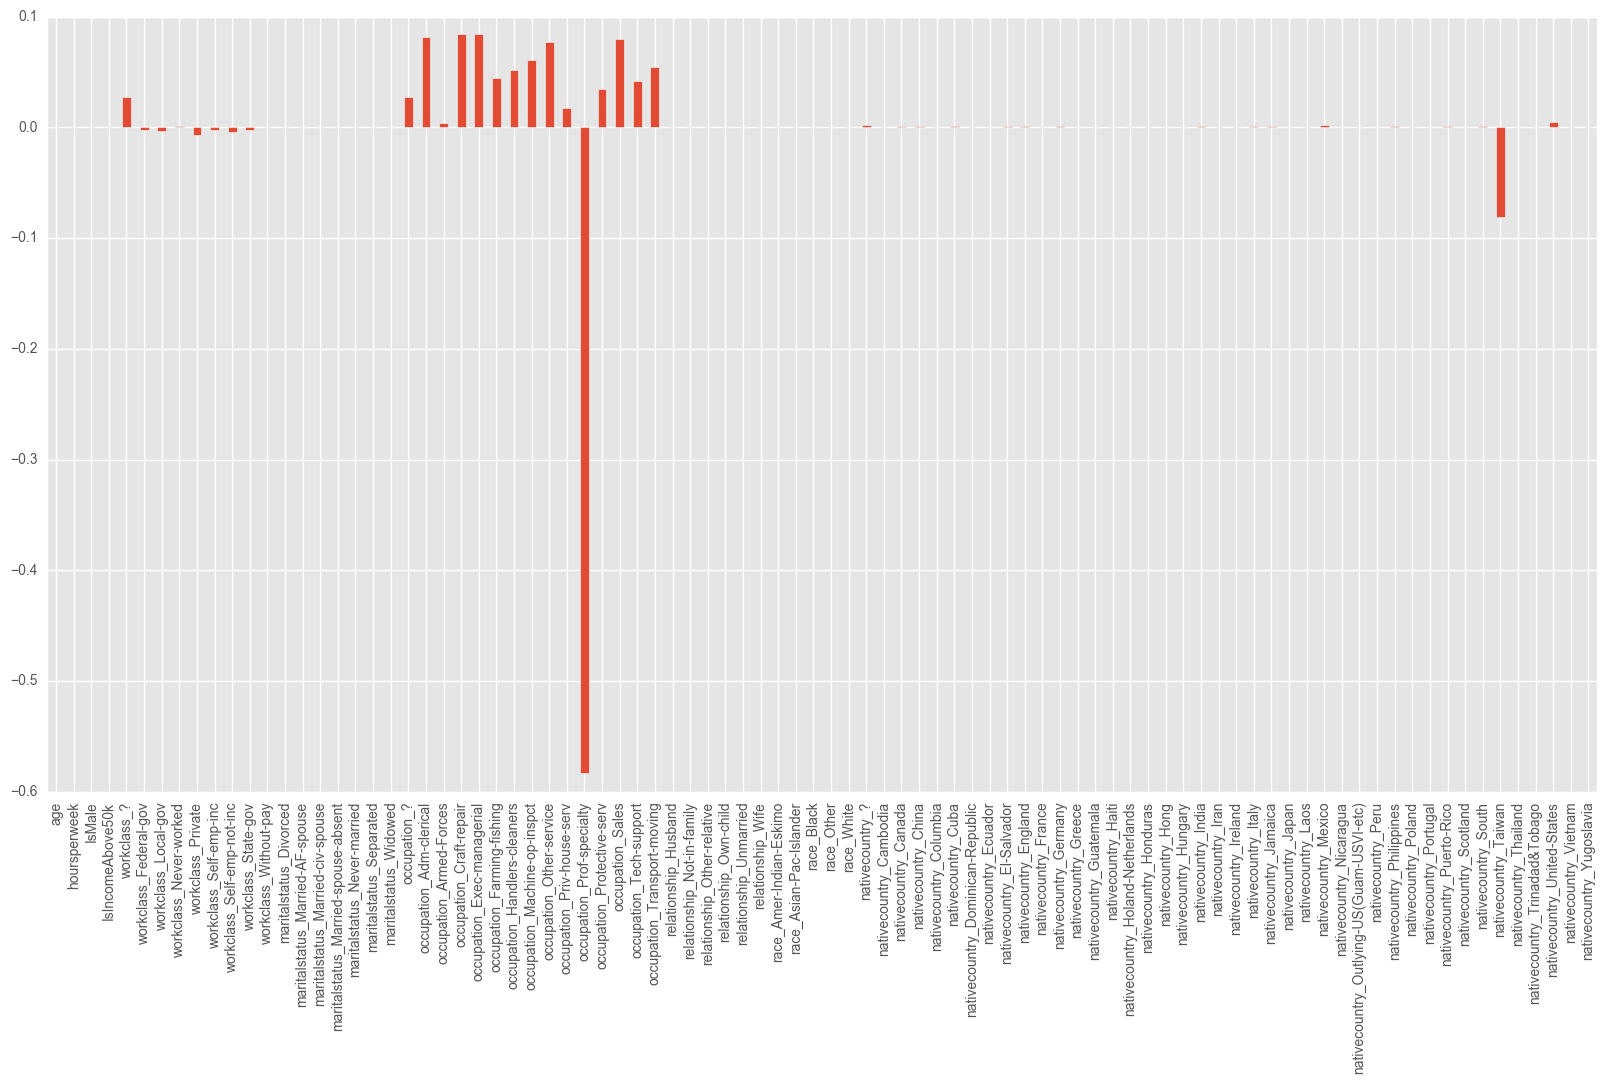

In [29]:
## SVM

# train the model
svm_clf_taskone = SVC(C=0.5, kernel='linear', gamma='auto', decision_function_shape='ovr') # get object
svm_clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)  # train object
y_hat_taskone = svm_clf_taskone.predict(X_test_scaled_taskone) # get test set predictions
acc_taskone = mt.recall_score(y_hat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
conf = mt.confusion_matrix(y_test_taskone,y_hat_taskone)
print('Recall of SVM classifier with linear model is: %.4f'%(acc_taskone))



%matplotlib inline
plt.style.use('ggplot')
weights = pd.Series(svm_clf_taskone.coef_[0],index=taskone.columns)
weights.plot(kind='bar', figsize=(20,10)).plot

svm_clf_taskone = SVC(C=0.5, kernel='poly', gamma='auto', decision_function_shape='ovr') # get object
svm_clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)  # train object
y_hat_taskone = svm_clf_taskone.predict(X_test_scaled_taskone) # get test set predictions
acc_taskone = mt.recall_score(y_hat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
conf = mt.confusion_matrix(y_test_taskone,y_hat_taskone)
print('Recall of SVM classifier with Polynomial model is: %.4f'%(acc_taskone))

svm_clf_taskone = SVC(C=0.5, kernel='rbf', gamma='auto', decision_function_shape='ovr') # get object
svm_clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)  # train object
y_hat_taskone = svm_clf_taskone.predict(X_test_scaled_taskone) # get test set predictions
acc_taskone = mt.recall_score(y_hat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
conf = mt.confusion_matrix(y_test_taskone,y_hat_taskone)
print('Recall of SVM classifier with rbf model is: %.4f'%(acc_taskone))

svm_clf_taskone = SVC(C=0.5, kernel='sigmoid', gamma='auto', decision_function_shape='ovr') # get object
svm_clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)  # train object
y_hat_taskone = svm_clf_taskone.predict(X_test_scaled_taskone) # get test set predictions
acc_taskone = mt.recall_score(y_hat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
conf = mt.confusion_matrix(y_test_taskone,y_hat_taskone)
print('Recall of SVM classifier with sigmoid model is: %.4f'%(acc_taskone))

We can see that the rbf model is the best out of all the four models. When we ran the model several times, the rbf was always the best model, and therefore we will take it as the result for the SVM method. It is impossible to plot the results per coefficient for the rbf model, however, from the linear method, which received a fairly close recall, we can see that the all the occupations variables have the highest impact, the "workclass-?" and the "nativecountry-Taiwan" variables have also a great impact, and the rest of the variables are redundant.

In [31]:
## Naive Bayes


clf_mnb_taskone = MultinomialNB(alpha=1.0)
clf_bnb_taskone = BernoulliNB(alpha=1.0, binarize=0.0)
clf_gau_taskone = GaussianNB()

clf_mnb_taskone.fit(X_train_taskone, y_train_taskone)
yhat_taskone = clf_mnb_taskone.predict(X_test_taskone)
acc_taskone = recall_score(yhat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of Naive Bayes Multinomial classifier is: %.2f'%(acc_taskone))

clf_bnb_taskone.fit(X_train_taskone, y_train_taskone)
yhat_taskone = clf_bnb_taskone.predict(X_test_taskone)
acc_taskone = recall_score(yhat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of Naive Bayes Bernouli classifier is: %.2f'%(acc_taskone))

clf_gau_taskone.fit(X_train_taskone, y_train_taskone)
yhat_taskone = clf_gau_taskone.predict(X_test_taskone)
acc_taskone = recall_score(yhat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of Naive Bayes Gaussian classifier is: %.2f'%(acc_taskone))


Recall of Naive Bayes Multinomial classifier is: 0.86
Recall of Naive Bayes Bernouli classifier is: 0.87
Recall of Naive Bayes Gaussian classifier is: 0.95


The most appropriate method in our case is the Gaussian distribution. We can see that is also derive the highest recall. When we ran this several times, sometimes the Multinomial classifier was higher than the Bernouli, but the Gaussian was always the highest. Again, regardless these results, we believe that the Gaussian classifier is the most appropriate here.

In [21]:
## KNN
# train the model
# calculate the accuracy and print it for various values of K
K = 1
clf_taskone = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)
yhat_taskone = clf_taskone.predict(X_test_scaled_taskone)
acc_taskone = mt.recall_score(yhat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_taskone))

K = 3
clf_taskone = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)
yhat_taskone = clf_taskone.predict(X_test_scaled_taskone)
acc_taskone = mt.recall_score(yhat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_taskone))

K = 5
clf_taskone = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)
yhat_taskone = clf_taskone.predict(X_test_scaled_taskone)
acc_taskone = mt.recall_score(yhat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_taskone))

K = 10
clf_taskone = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)
yhat_taskone = clf_taskone.predict(X_test_scaled_taskone)
acc_taskone = mt.recall_score(yhat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_taskone))

K = 20
clf_taskone = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)
yhat_taskone = clf_taskone.predict(X_test_scaled_taskone)
acc_taskone = mt.recall_score(yhat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_taskone))

K = 50
clf_taskone = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)
yhat_taskone = clf_taskone.predict(X_test_scaled_taskone)
acc_taskone = mt.recall_score(yhat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_taskone))

K = 80
clf_taskone = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)
yhat_taskone = clf_taskone.predict(X_test_scaled_taskone)
acc_taskone = mt.recall_score(yhat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_taskone))

Recall of KNN classifier with 1 neighbors is: 0.8522
Recall of KNN classifier with 3 neighbors is: 0.8571
Recall of KNN classifier with 5 neighbors is: 0.8596
Recall of KNN classifier with 10 neighbors is: 0.8678
Recall of KNN classifier with 20 neighbors is: 0.8630
Recall of KNN classifier with 50 neighbors is: 0.8547
Recall of KNN classifier with 80 neighbors is: 0.8487


We can see that when we use 1-10 neighbors, the recall grade is higher the more neighbors we use. However, from 10-80 neighbors, it is actually reversed, and the more neighbors we use, the lower the recall grade we get. This tradeoff make sense, and we will then take the 10 neighbors for our model.

Task two-

In [24]:
# we want to predict the X and y data as follows:
if 'WomenAbove62' in tasktwo:
    y_tasktwo = tasktwo['WomenAbove62'].values # get the labels we want
    del tasktwo['WomenAbove62'] # get rid of the class label
    X_tasktwo = tasktwo.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations_tasktwo = 3
cv_object_tasktwo = StratifiedShuffleSplit(n_splits=num_cv_iterations_tasktwo, test_size  = 0.2, random_state=0)
                         
print(cv_object_tasktwo)

# okay, so run through the cross validation loop and set the training and testing variable for one single iteration

for train_indices_tasktwo, test_indices_tasktwo in cv_object_tasktwo.split(X_tasktwo,y_tasktwo): 
    X_train_tasktwo = X_tasktwo[train_indices_tasktwo]
    y_train_tasktwo = y_tasktwo[train_indices_tasktwo]
    X_test_tasktwo = X_tasktwo[test_indices_tasktwo]
    y_test_tasktwo = y_tasktwo[test_indices_tasktwo]


scl_obj = StandardScaler()   
scl_obj.fit(X_train_tasktwo)

X_train_scaled_tasktwo = scl_obj.transform(X_train_tasktwo) # apply to training
X_test_scaled_tasktwo = scl_obj.transform(X_test_tasktwo) # apply those means and std to the test set (without snooping at the test set values)

StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.2,
            train_size=None)


/Users/eyalgreenberg/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.



Recall of SVM classifier with linear model is: 0.0000
Recall of SVM classifier with Polynomial model is: 0.5385
Recall of SVM classifier with rbf model is: 0.6087
Recall of SVM classifier with sigmoid model is: 0.0000


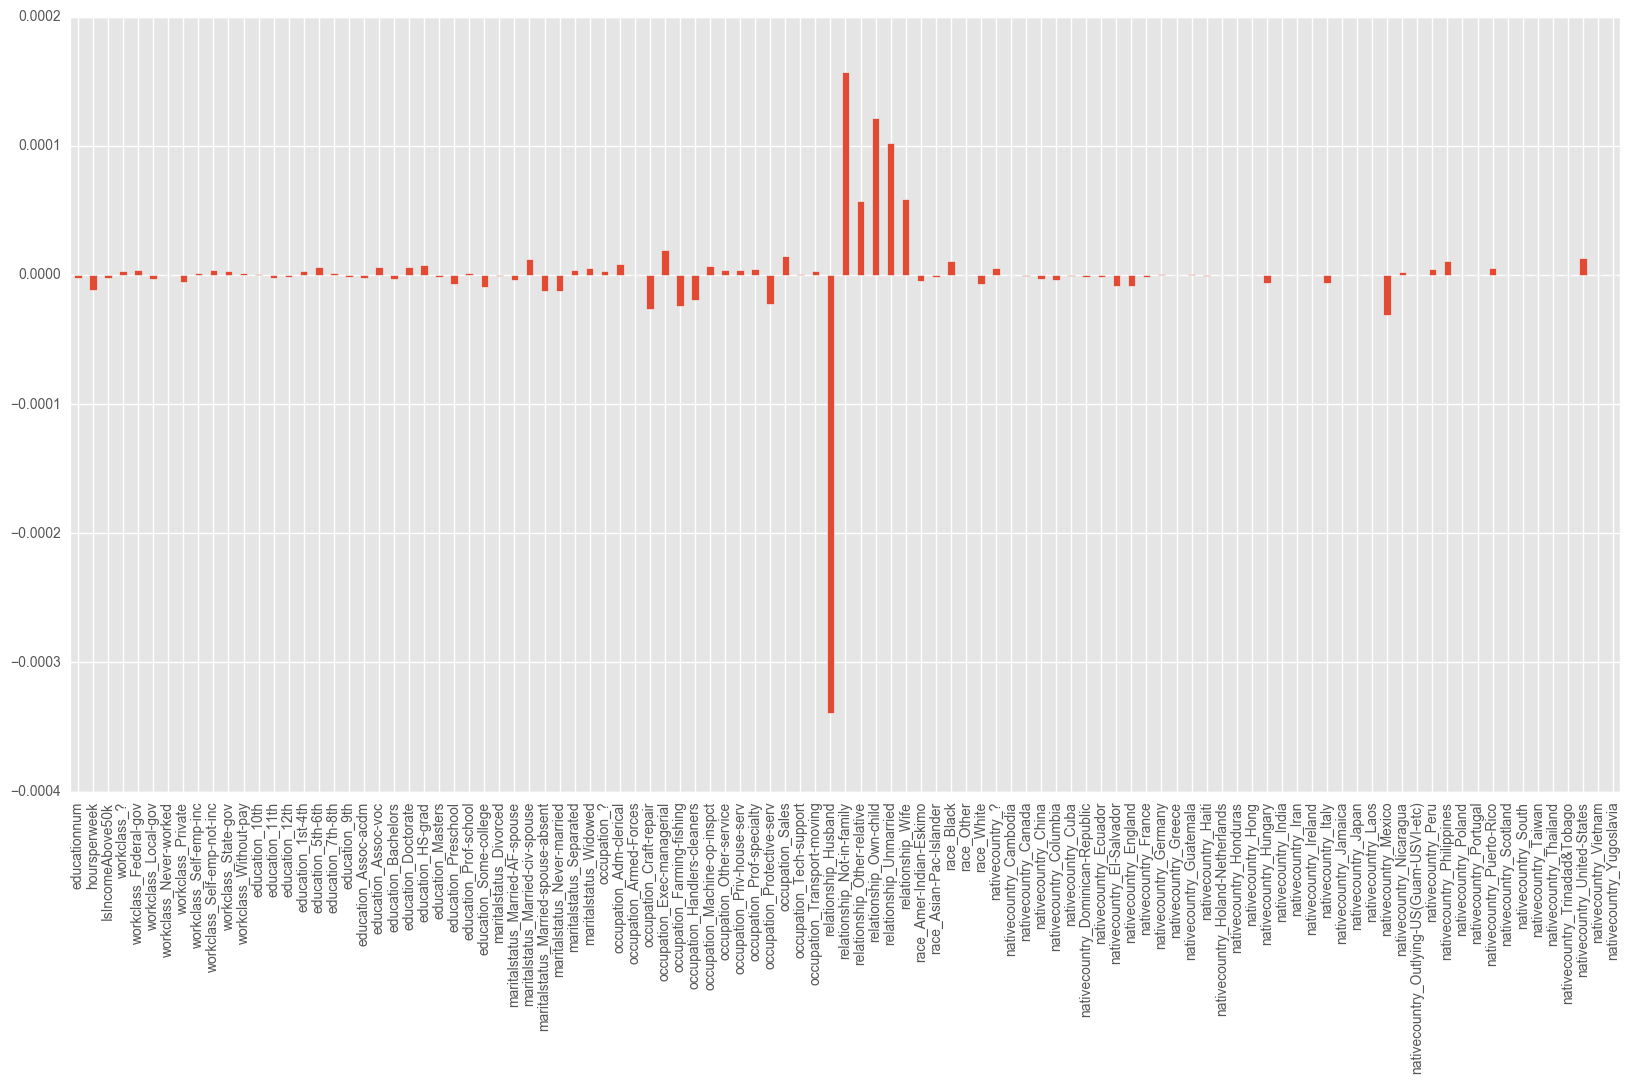

In [32]:
## SVM

# train the model
svm_clf_tasktwo = SVC(C=0.5, kernel='linear', gamma='auto', decision_function_shape='ovr') # get object
svm_clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)  # train object
y_hat_tasktwo = svm_clf_tasktwo.predict(X_test_scaled_tasktwo) # get test set predictions
acc_tasktwo = mt.recall_score(y_hat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
conf = mt.confusion_matrix(y_test_tasktwo,y_hat_tasktwo)
print('Recall of SVM classifier with linear model is: %.4f'%(acc_tasktwo))



%matplotlib inline
plt.style.use('ggplot')
weights = pd.Series(svm_clf_tasktwo.coef_[0],index=tasktwo.columns)
weights.plot(kind='bar', figsize=(20,10)).plot

svm_clf_tasktwo = SVC(C=0.5, kernel='poly', gamma='auto', decision_function_shape='ovr') # get object
svm_clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)  # train object
y_hat_tasktwo = svm_clf_tasktwo.predict(X_test_scaled_tasktwo) # get test set predictions
acc_tasktwo = mt.recall_score(y_hat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
conf = mt.confusion_matrix(y_test_tasktwo,y_hat_tasktwo)
print('Recall of SVM classifier with Polynomial model is: %.4f'%(acc_tasktwo))

svm_clf_tasktwo = SVC(C=0.5, kernel='rbf', gamma='auto', decision_function_shape='ovr') # get object
svm_clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)  # train object
y_hat_tasktwo = svm_clf_tasktwo.predict(X_test_scaled_tasktwo) # get test set predictions
acc_tasktwo = mt.recall_score(y_hat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
conf = mt.confusion_matrix(y_test_tasktwo,y_hat_tasktwo)
print('Recall of SVM classifier with rbf model is: %.4f'%(acc_tasktwo))

svm_clf_tasktwo = SVC(C=0.5, kernel='sigmoid', gamma='auto', decision_function_shape='ovr') # get object
svm_clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)  # train object
y_hat_tasktwo = svm_clf_tasktwo.predict(X_test_scaled_tasktwo) # get test set predictions
acc_tasktwo = mt.recall_score(y_hat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
conf = mt.confusion_matrix(y_test_tasktwo,y_hat_tasktwo)
print('Recall of SVM classifier with sigmoid model is: %.4f'%(acc_tasktwo))


Like in task one, the rbf is the best model. However, we can see that the linear and sigmoid models are useless, with recall of zero. We can also see the the rbf and the polynomial models are not as good as we expect. We will keep analyze the other three models to examine the results.

In [33]:
## Naive Bayes


clf_mnb_tasktwo = MultinomialNB(alpha=1.0)
clf_bnb_tasktwo = BernoulliNB(alpha=1.0, binarize=0.0)
clf_gau_tasktwo = GaussianNB()

clf_mnb_tasktwo.fit(X_train_tasktwo, y_train_tasktwo)
yhat_tasktwo = clf_mnb_tasktwo.predict(X_test_tasktwo)
acc_tasktwo = recall_score(yhat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of Naive Bayes Multinomial classifier is: %.2f'%(acc_tasktwo))

clf_bnb_tasktwo.fit(X_train_tasktwo, y_train_tasktwo)
yhat_tasktwo = clf_bnb_tasktwo.predict(X_test_tasktwo)
acc_tasktwo = recall_score(yhat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of Naive Bayes Bernouli classifier is: %.2f'%(acc_tasktwo))

clf_gau_tasktwo.fit(X_train_tasktwo, y_train_tasktwo)
yhat_tasktwo = clf_gau_tasktwo.predict(X_test_tasktwo)
acc_tasktwo = recall_score(yhat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of Naive Bayes Gaussian classifier is: %.2f'%(acc_tasktwo))

Recall of Naive Bayes Multinomial classifier is: 0.49
Recall of Naive Bayes Bernouli classifier is: 0.34
Recall of Naive Bayes Gaussian classifier is: 0.03


The results of the Naïve Bayes model, in all three distributions, are poor. Regardless the results that show the Multinomial distribution is the best, we think that it is more appropriate to use the Gaussian distribution. However, it’s recall is so poor that it is basically useless.

In [34]:
## KNN
# train the model
# calculate the accuracy and print it for various values of K
K = 1
clf_tasktwo = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)
yhat_tasktwo = clf_tasktwo.predict(X_test_scaled_tasktwo)
acc_tasktwo = mt.recall_score(yhat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_tasktwo))

K = 3
clf_tasktwo = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)
yhat_tasktwo = clf_tasktwo.predict(X_test_scaled_tasktwo)
acc_tasktwo = mt.recall_score(yhat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_tasktwo))

K = 5
clf_tasktwo = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)
yhat_tasktwo = clf_tasktwo.predict(X_test_scaled_tasktwo)
acc_tasktwo = mt.recall_score(yhat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_tasktwo))

K = 10
clf_tasktwo = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)
yhat_tasktwo = clf_tasktwo.predict(X_test_scaled_tasktwo)
acc_tasktwo = mt.recall_score(yhat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_tasktwo))

K = 20
clf_tasktwo = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)
yhat_tasktwo = clf_tasktwo.predict(X_test_scaled_tasktwo)
acc_tasktwo = mt.recall_score(yhat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_tasktwo))

K = 50
clf_tasktwo = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)
yhat_tasktwo = clf_tasktwo.predict(X_test_scaled_tasktwo)
acc_tasktwo = mt.recall_score(yhat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_tasktwo))

K = 80
clf_tasktwo = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)
yhat_tasktwo = clf_tasktwo.predict(X_test_scaled_tasktwo)
acc_tasktwo = mt.recall_score(yhat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of KNN classifier with %d neighbors is: %.4f'%(K,acc_tasktwo))


Recall of KNN classifier with 1 neighbors is: 0.3063
Recall of KNN classifier with 3 neighbors is: 0.5000
Recall of KNN classifier with 5 neighbors is: 0.5185
Recall of KNN classifier with 10 neighbors is: 0.6154
Recall of KNN classifier with 20 neighbors is: 0.6667
Recall of KNN classifier with 50 neighbors is: 0.6250
Recall of KNN classifier with 80 neighbors is: 0.6190


As we identified in task one, we can see here the same pattern - when we use 1-20 neighbors, the recall grade is higher the more neighbors we use. However, from 20-80 neighbors, it is actually reversed, and the more neighbors we use, the lower the recall grade we get. In task one the threshold was 10, while here it’s 20 neighbors, but the pattern is still the same. Again, this tradeoff makes sense, and we will then take the 20 neighbors for our model.

#### [10 pts] Discuss the advantages of each model for each classification task, if any.  If there are not advantages, explain why.  Is any model better than another?  Is the difference significant with 95% confidence?  *Use proper statistical comparison methods.* You must use statistical comparison techniques - be sure they are appropriate for your chosen method of validation as discussed in Unit 7 of the course.


#### [10 pts] Which attributes from your analysis are most important?  Use proper methods discussed in class to evaluate the importance of different attributes.  Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

In [77]:
# we will calculate the statistical difference between the accuracies in each tasks (we will use 95% confedence level)-
# Task one-
print('Task one')
print('________')

error_SVM = 1-0.8526 #we use the recall of the rbf model as explained above
Var_SVM = ((1-0.8526)*0.8526)/(0.2*32561) # n is 20% of the total datase

error_NaiveBayes = 1-0.95 #we use the recall of the rbf model as explained above
Var_NaiveBayes = ((1-0.95)*0.95)/(0.2*32561) # n is 20% of the total datase

error_KNN = 1-0.8678 #we use the recall of the model with 10 neighbors as explained above
Var_KNN = ((1-0.8678)*0.8678)/(0.2*32561) # n is 20% of the total datase

# Models comparison-
# We will assume normal distribution and will deduct one model from the other
# SVM vs. NaiveBayes:
# Nd((error_SVM-error_NaiveBayes),(Var_SVM+Var_NaiveBayes))
# CI((error_SVM-error_NaiveBayes)+/-1.96*((Var_SVM+Var_NaiveBayes))**0.5)
CI_minus = ((error_SVM-error_NaiveBayes)-1.96*((Var_SVM+Var_NaiveBayes))**0.5)
CI_plus = ((error_SVM-error_NaiveBayes)+1.96*((Var_SVM+Var_NaiveBayes))**0.5)
print('SVM vs. NaiveBayes')
print('The confedence interval is [%.4f,%.4f]'%(CI_minus,CI_plus))
if (0 > CI_minus) and (0 < CI_plus):
    print('Zero is within the CI, then we cannot reject the null that the models recalls are different ')
else:
    print('Zero is not within the CI, then we can reject the null that the models recalls are the same. \n'
         'In other words - we can conclude that the models are different')
print('-----------')
# SVM vs. KNN:
CI_minus = ((error_SVM-error_KNN)-1.96*((Var_SVM+Var_KNN))**0.5)
CI_plus = ((error_SVM-error_KNN)+1.96*((Var_SVM+Var_KNN))**0.5)

print('SVM vs. KNN')
print('The confedence interval is [%.4f,%.4f]'%(CI_minus,CI_plus))
if (0 > CI_minus) and (0 < CI_plus):
    print('Zero is within the CI, then we cannot reject the null that the models recalls are different ')
else:
    print('Zero is not within the CI, then we can reject the null that the models recalls are the same. \n'
         'In other words - we can conclude that the models are different')
print('-----------')

# KNN vs. NaiveBayes:
CI_minus = ((error_KNN-error_NaiveBayes)-1.96*((Var_KNN+Var_NaiveBayes))**0.5)
CI_plus = ((error_KNN-error_NaiveBayes)+1.96*((Var_KNN+Var_NaiveBayes))**0.5)

print('KNN vs. NaiveBayes')
print('The confedence interval is [%.4f,%.4f]'%(CI_minus,CI_plus))
if (0 > CI_minus) and (0 < CI_plus):
    print('Zero is within the CI, then we cannot reject the null that the models recalls are the same. \n'
          'In other words - we cannot conclude that the models are different')
else:
    print('Zero is not within the CI, then we can reject the null that the models recalls are the same. \n'
         'In other words - we can conclude that the models are different')
print('-----------')

# Task two-
print('Task two')
print('________')

error_SVM = 1-0.6087 #we use the recall of the rbf model as explained above
Var_SVM = ((1-0.6087)*0.6087)/(0.2*32561) # n is 20% of the total datase

error_NaiveBayes = 1-0.03 #we use the recall of the rbf model as explained above
Var_NaiveBayes = ((1-0.03)*0.03)/(0.2*32561) # n is 20% of the total datase

error_KNN = 1-0.6667 #we use the recall of the model with 10 neighbors as explained above
Var_KNN = ((1-0.6667)*0.6667)/(0.2*32561) # n is 20% of the total datase

# Models comparison-
# We will assume normal distribution and will deduct two model from the other
# SVM vs. NaiveBayes:
# Nd((error_SVM-error_NaiveBayes),(Var_SVM+Var_NaiveBayes))
# CI((error_SVM-error_NaiveBayes)+/-1.96*((Var_SVM+Var_NaiveBayes))**0.5)
CI_minus = ((error_SVM-error_NaiveBayes)-1.96*((Var_SVM+Var_NaiveBayes))**0.5)
CI_plus = ((error_SVM-error_NaiveBayes)+1.96*((Var_SVM+Var_NaiveBayes))**0.5)
print('SVM vs. NaiveBayes')
print('The confedence interval is [%.4f,%.4f]'%(CI_minus,CI_plus))
if (0 > CI_minus) and (0 < CI_plus):
    print('Zero is within the CI, then we cannot reject the null that the models recalls are different ')
else:
    print('Zero is not within the CI, then we can reject the null that the models recalls are the same. \n'
         'In other words - we can conclude that the models are different')
print('-----------')
# SVM vs. KNN:
CI_minus = ((error_SVM-error_KNN)-1.96*((Var_SVM+Var_KNN))**0.5)
CI_plus = ((error_SVM-error_KNN)+1.96*((Var_SVM+Var_KNN))**0.5)

print('SVM vs. KNN')
print('The confedence interval is [%.4f,%.4f]'%(CI_minus,CI_plus))
if (0 > CI_minus) and (0 < CI_plus):
    print('Zero is within the CI, then we cannot reject the null that the models recalls are different ')
else:
    print('Zero is not within the CI, then we can reject the null that the models recalls are the same. \n'
         'In other words - we can conclude that the models are different')
print('-----------')

# KNN vs. NaiveBayes:
CI_minus = ((error_KNN-error_NaiveBayes)-1.96*((Var_KNN+Var_NaiveBayes))**0.5)
CI_plus = ((error_KNN-error_NaiveBayes)+1.96*((Var_KNN+Var_NaiveBayes))**0.5)

print('KNN vs. NaiveBayes')
print('The confedence interval is [%.4f,%.4f]'%(CI_minus,CI_plus))
if (0 > CI_minus) and (0 < CI_plus):
    print('Zero is within the CI, then we cannot reject the null that the models recalls are the same. \n'
          'In other words - we cannot conclude that the models are different')
else:
    print('Zero is not within the CI, then we can reject the null that the models recalls are the same. \n'
         'In other words - we can conclude that the models are different')
print('-----------')

Task one
________
SVM vs. NaiveBayes
The confedence interval is [0.0873,0.1075]
Zero is not within the CI, then we can reject the null that the models recalls are the same. 
In other words - we can conclude that the models are different
-----------
SVM vs. KNN
The confedence interval is [0.0033,0.0271]
Zero is not within the CI, then we can reject the null that the models recalls are the same. 
In other words - we can conclude that the models are different
-----------
KNN vs. NaiveBayes
The confedence interval is [0.0724,0.0920]
Zero is not within the CI, then we can reject the null that the models recalls are the same. 
In other words - we can conclude that the models are different
-----------
Task two
________
SVM vs. NaiveBayes
The confedence interval is [-0.5913,-0.5661]
Zero is not within the CI, then we can reject the null that the models recalls are the same. 
In other words - we can conclude that the models are different
-----------
SVM vs. KNN
The confedence interval is [0.041

For both task one and task two, and for all three methods, we have received confidence intervals that do not include zero. This leads us to the conclusion that the models are different. 
For taskone, we will take the naive bayes (Gaussian) as the best classifier, with recall of 0.95. Nevertheless, we can see from the SVM linear model, that only the occupations variables, the "workclass-?" and the "nativecountry-Taiwan" variables have influence on the results. 
For task two we have received fairly poor recall ranks. We assume this is a result of a too much difficult model to classify from the dataset given. In other words, from the data given to the models, it is beyond our ability to create a better model. Still, if we need to choose the best method of all the three, we will take the KNN with 20 neighbors, which resulted in recall rank of 0.6667.

## Deployment (5 pts total)

#### How useful is your model for interested parties (i.e. the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties?  How would you deploy your model for interested parties?  What other data should be collected?  How often would the model need to be updated, etc.?

For task one, our model is quite good, and we would definitely recommend using it for the business purposes. Since all three models are quite well, a further step that can be taken is a more detailed comparison between the models, and taking the best of them.
For task two, we definitely recommend not using the model as it is now. We think that collecting more data is crucial. This data can be related to the women over 62, like habits of women in this age, places of interests they visit etc. An example can be try to collect the amount spent on health, or the number of visits to the doctor, as it is known that older people tend to be less healthy.


## Exceptional Work (10 pts total)

#### You have free reign to provide add'l analysis

#### One idea: grid research parameters in a parallelized fashion and visualize the performances across attributes.  Which parameters are most significant for making a good model for each classification algorithm?

In [101]:
# We have decided to perform a random forest analysis on both task one and two as an additional work.

## random forest

from sklearn.ensemble import RandomForestClassifier

## taskone
clf_taskone = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False,
                             n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
clf_taskone.fit(X_train_scaled_taskone, y_train_taskone)
yhat_taskone = clf_taskone.predict(X_test_scaled_taskone)
acc_taskone = mt.recall_score(yhat_taskone, y_test_taskone, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of random forest classifier is: %.4f'%(acc_taskone))

## tasktwo
clf_tasktwo = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False,
                             n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
clf_tasktwo.fit(X_train_scaled_tasktwo, y_train_tasktwo)
yhat_tasktwo = clf_tasktwo.predict(X_test_scaled_tasktwo)
acc_tasktwo = mt.recall_score(yhat_tasktwo, y_test_tasktwo, labels=None, pos_label=1, average='binary', sample_weight=None)
print('Recall of random forest classifier is: %.4f'%(acc_tasktwo))

Recall of random forest classifier is: 0.8612
Recall of random forest classifier is: 0.5185


We can see that with the random forest classifier, still the recall of task two is still quite low, compared to taskone. However, this recall (0.5185) is higher than we received in all three models above (SVM, naive bayes and KNN) for task two.

#### References:

Introduction To Data Mining by Tan, Steinbach, and Kumar, chapters 4 and 5

https://github.com/turkeyvolvo/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

http://scikit-learn.org/stable/modules/cross_validation.html

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit.split

http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html

http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

http://scikit-learn.org/stable/modules/sgd.html#regression

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

http://scikit-learn.org/stable/modules/kernel_approximation.html

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

http://scikit-learn.org/stable/modules/neighbors.html

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

http://scikit-learn.org/stable/modules/linear_model.html#lasso

http://scikit-learn.org/stable/modules/linear_model.html#passive-aggressive-algorithms

http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

http://scikit-learn.org/stable/modules/tree.html#tree

http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression

http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups_vectorized.html

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

http://scikit-learn.org/stable/modules/svm.html#classification

http://scikit-learn.org/stable/modules/neighbors.html#nearest-centroid-classifier

http://stackoverflow.com/questions/8855574/convert-ndarray-from-float64-to-integer

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score

http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB

http://scikit-learn.org/stable/modules/ensemble.html

http://scikit-learn.org/stable/modules/sgd.html#classification

http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#newsgroups

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit

http://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html#sphx-glr-auto-examples-svm-plot-weighted-samples-py

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py

http://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html#sklearn.neighbors.NearestCentroid

http://scikit-learn.org/stable/modules/svm.html#svm

http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

http://scikit-learn.org/stable/auto_examples/calibration/plot_calibration.html#sphx-glr-auto-examples-calibration-plot-calibration-py

http://scikit-learn.org/stable/modules/ensemble.html#random-forests

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

http://scikit-learn.org/stable/modules/learning_curve.html

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split

http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics

http://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/